# 🔍 Azure AutoML for Images (Object Detection)
## 3. Object detection model inferencing

![Alt text](img/img.jpg)

This notebook is designed for Azure Machine Learning model deployment and interaction. It includes:

- Connects to an Azure ML online endpoint (swimming-pool-endpoint) and deployment (pool-mlflow-deploy).
- Prepares for model inference and possibly integrates with Gradio for UI interaction.


In [1]:
import asyncio
import base64
import datetime
import gradio as gr
import io
import json
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import psutil
import sys
import shutil
import tempfile
import threading
import time

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from concurrent.futures import ThreadPoolExecutor
from dotenv import load_dotenv
from PIL import Image, ImageDraw, ImageFont
from typing import Tuple

In [2]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 29-Oct-2025 15:21:24


In [4]:
processor = platform.processor()
cpu_count = psutil.cpu_count(logical=True)
ram_total = round(psutil.virtual_memory().total / (1024 ** 3), 2)
ram_available = round(psutil.virtual_memory().available / (1024 ** 3), 2)

disk_total, disk_used, disk_free = shutil.disk_usage("/")
disk_total_gb = disk_total / (1024 ** 3)
disk_free_gb = disk_free / (1024 ** 3)
disk_free_percent = disk_free / disk_total

print(f"🖥️ Processor: {processor}")
print(f"🧠 CPU Cores: {cpu_count}")
print(f"💾 RAM Total: {ram_total} GB")
print(f"📗 RAM Available: {ram_available} GB")
print(f"📀 Disk Total: {disk_total_gb:.2f} GB")
print(f"📂 Disk Free: {disk_free_gb:.2f} GB ({disk_free_percent:.0%})")

🖥️ Processor: x86_64
🧠 CPU Cores: 48
💾 RAM Total: 188.88 GB
📗 RAM Available: 183.02 GB
📀 Disk Total: 118.05 GB
📂 Disk Free: 39.59 GB (34%)


## 1. Settings

In [5]:
load_dotenv("azure.env")

credential = DefaultAzureCredential()

ml_client = MLClient(
    credential=credential,
    subscription_id=os.getenv("subscription_id"),
    resource_group_name=os.getenv("resource_group"),
    workspace_name=os.getenv("workspace"),
)

In [6]:
online_endpoint_name = "swimmingpool-managedendpoint"
deployment_name = "pool-mlflow"

In [7]:
MODEL_DIR = "model"

os.makedirs(MODEL_DIR, exist_ok=True)

In [8]:
RESULTS_DIR = "results"

os.makedirs(RESULTS_DIR, exist_ok=True)

## 2. Helper

In [9]:
def pools_detection(
        image_file: str,
        results_df: pd.DataFrame = None,
        view: str = True) -> Tuple[dict, pd.DataFrame]:
    """
    Detect pools in an image using an Azure ML online endpoint and store results in a DataFrame.
    
    Args:
        image_file (str): Path to the image file.
        ml_client: Azure ML client instance.
        online_endpoint_name (str): Name of the online endpoint.
        deployment_name (str): Name of the deployment.
    
    Returns:
        Tuple[dict, pd.DataFrame]: JSON response from the endpoint and updated DataFrame.
    """
    try:
        # Initialize DataFrame if not provided
        if results_df is None:
            results_df = pd.DataFrame(columns=[
                'image_file', 'detection_id', 'label', 'score', 'top_x',
                'top_y', 'bottom_x', 'bottom_y', 'confidence_level'
            ])

        # Read and encode image
        with open(image_file, "rb") as img:
            encoded_image = base64.encodebytes(img.read()).decode("utf-8")

        # Prepare request payload
        request_json = {
            "input_data": {
                "columns": ["image"],
                "data": [encoded_image],
            }
        }

        # Save request to file
        request_file_name = "request.json"
        with open(request_file_name, "w") as request_file:
            json.dump(request_json, request_file)

        # Invoke endpoint
        response = ml_client.online_endpoints.invoke(
            endpoint_name=online_endpoint_name,
            deployment_name=deployment_name,
            request_file=request_file_name,
        )

        results = json.loads(response)
        if view:
            print(f"Predictions for image {image_file}:\n")

        for item_idx, item in enumerate(results, 1):
            boxes = item.get('boxes', [])
            if view:
                print(f"💧 Number of swimming pools = {len(boxes)}\n")

            for box_idx, detection in enumerate(boxes, 1):
                label = detection.get('label', 'unknown').upper()
                score = detection.get('score', 0)
                box = detection.get('box', {})

                # Determine confidence level based on score
                if score >= 0.80:
                    confidence_emoji = "🟢"
                    confidence_level = "High"
                elif score >= 0.70:
                    confidence_emoji = "🟡"
                    confidence_level = "Medium"
                else:
                    confidence_emoji = "🟠"
                    confidence_level = "Low"

                top_x = box.get('topX', 0)
                top_y = box.get('topY', 0)
                bottom_x = box.get('bottomX', 0)
                bottom_y = box.get('bottomY', 0)

                if view:
                    print(
                        f"{box_idx}: {label} with score = {score:.2%} {confidence_emoji}"
                    )
                    print(
                        f"Top-Left = ({top_x:.4f}, {top_y:.4f}) Bottom-Right: ({bottom_x:.4f}, {bottom_y:.4f})"
                    )
                    print()

                # Append detection to DataFrame
                new_row = {
                    'image_file': image_file,
                    'detection_id': box_idx,
                    'label': label,
                    'score': score,
                    'top_x': top_x,
                    'top_y': top_y,
                    'bottom_x': bottom_x,
                    'bottom_y': bottom_y,
                    'confidence_level': confidence_level
                }
                results_df = pd.concat(
                    [results_df, pd.DataFrame([new_row])], ignore_index=True)

        return results, results_df

    except FileNotFoundError:
        raise ValueError(f"Image file '{image_file}' not found.")
    except Exception as e:
        raise RuntimeError(f"Error during pool detection: {e}")

In [10]:
def visualize_predictions(image_file,
                          predictions,
                          min_confidence=0.7,
                          figsize=(8, 8)):
    """
    Display an image with beautifully styled bounding boxes for predictions above a confidence threshold.
    Parameters:
    - image_file (str): Path to the image file.
    - predictions (list): List of prediction dictionaries with 'label', 'score', and 'box'.
    - min_confidence (float): Minimum confidence to display a bounding box.
    - figsize (tuple): Size of the matplotlib figure.
    """
    # Load image
    image_array = mpimg.imread(image_file)
    pil_image = Image.fromarray(image_array.astype("uint8"))
    image_width, image_height = pil_image.size

    # Create plot with white background
    fig, axis = plt.subplots(1, figsize=figsize, facecolor='white')
    axis.set_facecolor('white')
    plt.axis('off')
    axis.imshow(image_array)

    # Color palette for boxes - vibrant and distinguishable colors
    colors = ["#00D9FF", "#39FF14", "#FF006E", "#FFBE0B", "#8338EC", "#3A86FF"]

    detected_count = 0

    # Draw bounding boxes
    for idx, detection in enumerate(predictions[0]["boxes"]):
        confidence = detection["score"]
        if confidence >= min_confidence:
            detected_count += 1

            bbox = detection["box"]
            y_start, x_start = bbox["topY"], bbox["topX"]
            y_end, x_end = bbox["bottomY"], bbox["bottomX"]
            box_left = image_width * x_start
            box_top = image_height * y_start
            box_width = image_width * (x_end - x_start)
            box_height = image_height * (y_end - y_start)

            # Select color
            box_color = colors[idx % len(colors)]

            # Draw rectangle with thicker, more prominent border
            bounding_box = patches.Rectangle(xy=(box_left, box_top),
                                             width=box_width,
                                             height=box_height,
                                             linewidth=3,
                                             edgecolor=box_color,
                                             facecolor="none",
                                             linestyle='-')
            axis.add_patch(bounding_box)

            # Add background for label text (semi-transparent rectangle)
            label_text = f"{detection['label']} = {confidence:.3f}"
            bbox_props = dict(boxstyle='round,pad=0.5',
                              facecolor=box_color,
                              alpha=0.85,
                              edgecolor='white',
                              linewidth=1.5)
            plt.text(box_left,
                     box_top - 15,
                     label_text,
                     color='white',
                     fontsize=11,
                     weight='bold',
                     bbox=bbox_props,
                     verticalalignment='bottom')

    # Add header info with styled background
    total_boxes = len(predictions[0]['boxes'])
    header_text = f"✓ {detected_count} of {total_boxes} objects detected (confidence ≥ {min_confidence:.0%})"
    now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')

    # Header background
    header_props = dict(boxstyle='round,pad=0.8',
                        facecolor='#1a1a1a',
                        alpha=0.9,
                        edgecolor='#00D9FF',
                        linewidth=2)
    plt.text(image_width * 0.5,
             image_height * 0.98,
             header_text,
             color='#00D9FF',
             fontsize=13,
             weight='bold',
             ha='center',
             va='top',
             bbox=header_props,
             transform=axis.transData)

    # Footer info
    footer_props = dict(boxstyle='round,pad=0.7',
                        facecolor='#1a1a1a',
                        alpha=0.88,
                        edgecolor='#39FF14',
                        linewidth=1.5)
    plt.text(image_width * 0.5,
             image_height * 0.02,
             f"Azure AutoML for Images  |  {now}",
             color='#39FF14',
             fontsize=10,
             ha='center',
             va='bottom',
             bbox=footer_props,
             transform=axis.transData)

    plt.tight_layout()
    plt.show()

## 3. Testing

In [11]:
TEST_DIR = "test"

test_images_list = [
    os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR)
    if os.path.splitext(f)[1].lower() in
    {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
]

In [12]:
len(test_images_list)

100

In [13]:
test_image = test_images_list[0]

In [14]:
start = time.time()
predictions, df = pools_detection(test_image)
print(f"✅ Done in {(time.time() - start):.3f} seconds")

Predictions for image test/image_001.png:

💧 Number of swimming pools = 2

1: POOL with score = 86.81% 🟢
Top-Left = (0.5167, 0.6790) Bottom-Right: (0.5733, 0.7404)

2: POOL with score = 82.65% 🟢
Top-Left = (0.2415, 0.0261) Bottom-Right: (0.2999, 0.0620)

✅ Done in 1.453 seconds


In [15]:
df.sort_values(by='score', ascending=False).style.background_gradient(subset=['score'], cmap='RdYlGn')

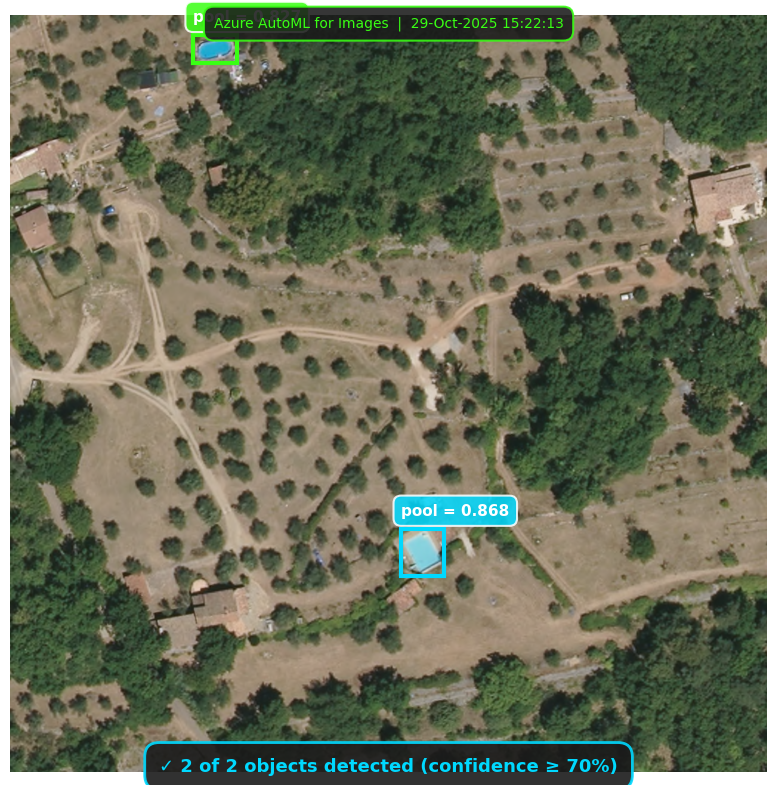

In [16]:
visualize_predictions(test_image, predictions, min_confidence=0.7)

In [17]:
test_image = test_images_list[20]
img = Image.open(test_image)

start = time.time()
predictions, df = pools_detection(test_image)
print(f"✅ Done in {(time.time() - start):.3f} seconds")

Predictions for image test/image_021.png:

💧 Number of swimming pools = 2

1: POOL with score = 85.32% 🟢
Top-Left = (0.5459, 0.3863) Bottom-Right: (0.6170, 0.4391)

2: POOL with score = 78.19% 🟡
Top-Left = (0.0563, 0.3358) Bottom-Right: (0.1212, 0.3713)

✅ Done in 1.375 seconds


In [18]:
df.sort_values(by='score', ascending=False).style.background_gradient(subset=['score'], cmap='RdYlGn')

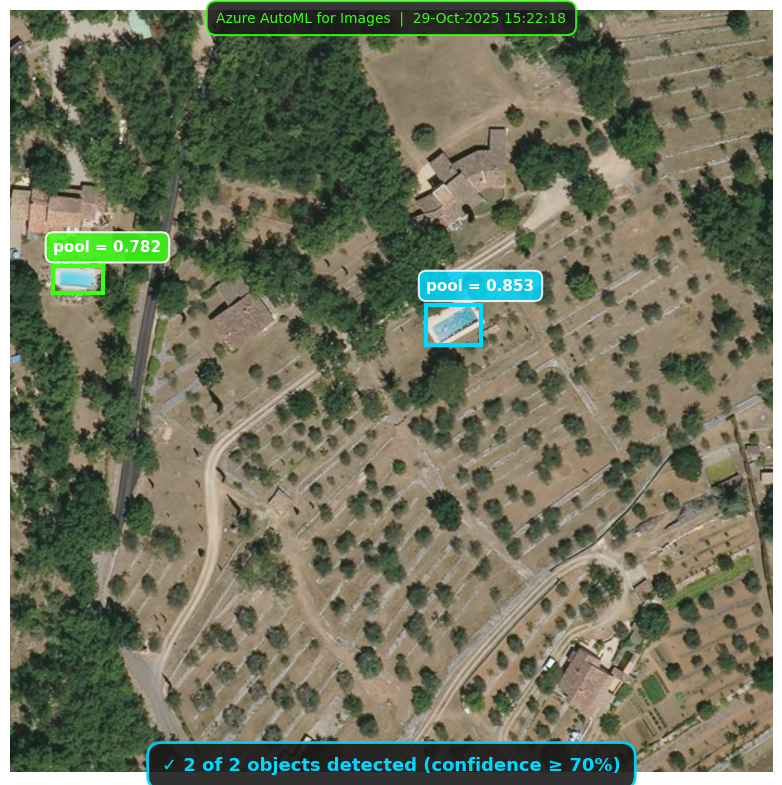

In [19]:
visualize_predictions(test_image, predictions, min_confidence=0.7)

In [20]:
test_image = test_images_list[35]
img = Image.open(test_image)

start = time.time()
predictions, df = pools_detection(test_image)
print(f"✅ Done in {(time.time() - start):.3f} seconds")

Predictions for image test/image_036.png:

💧 Number of swimming pools = 5

1: POOL with score = 83.37% 🟢
Top-Left = (0.6432, 0.2825) Bottom-Right: (0.6867, 0.3240)

2: POOL with score = 79.01% 🟡
Top-Left = (0.5892, 0.0679) Bottom-Right: (0.6628, 0.1046)

3: POOL with score = 76.70% 🟡
Top-Left = (0.8565, 0.5379) Bottom-Right: (0.9085, 0.5740)

4: POOL with score = 76.44% 🟡
Top-Left = (0.4092, 0.1500) Bottom-Right: (0.4409, 0.1803)

5: POOL with score = 66.48% 🟠
Top-Left = (0.3104, 0.9095) Bottom-Right: (0.3372, 0.9332)

✅ Done in 0.993 seconds


In [21]:
df.sort_values(by='score', ascending=False).style.background_gradient(subset=['score'], cmap='RdYlGn')

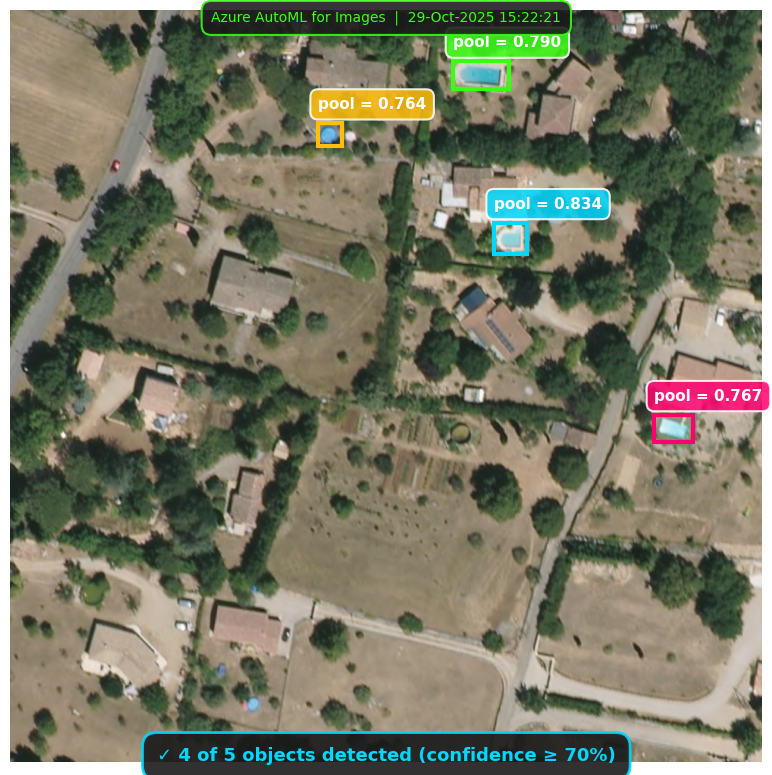

In [22]:
visualize_predictions(test_image, predictions, min_confidence=0.7)

In [23]:
test_image = test_images_list[85]
img = Image.open(test_image)

start = time.time()
predictions, df = pools_detection(test_image)
print(f"✅ Done in {(time.time() - start):.3f} seconds")

Predictions for image test/image_086.png:

💧 Number of swimming pools = 8

1: POOL with score = 84.87% 🟢
Top-Left = (0.7119, 0.6160) Bottom-Right: (0.7836, 0.6671)

2: POOL with score = 82.48% 🟢
Top-Left = (0.9400, 0.0138) Bottom-Right: (0.9774, 0.0652)

3: POOL with score = 81.70% 🟢
Top-Left = (0.8479, 0.7321) Bottom-Right: (0.9161, 0.7707)

4: POOL with score = 78.50% 🟡
Top-Left = (0.6654, 0.4368) Bottom-Right: (0.7288, 0.4650)

5: POOL with score = 77.96% 🟡
Top-Left = (0.9061, 0.1490) Bottom-Right: (0.9393, 0.1913)

6: POOL with score = 71.98% 🟡
Top-Left = (0.7650, 0.8332) Bottom-Right: (0.8013, 0.8670)

7: POOL with score = 71.22% 🟡
Top-Left = (0.2317, 0.1672) Bottom-Right: (0.2650, 0.1978)

8: POOL with score = 42.23% 🟠
Top-Left = (0.4667, 0.0012) Bottom-Right: (0.5443, 0.0169)

✅ Done in 1.227 seconds


In [24]:
df.sort_values(by='score', ascending=False).style.background_gradient(subset=['score'], cmap='RdYlGn')

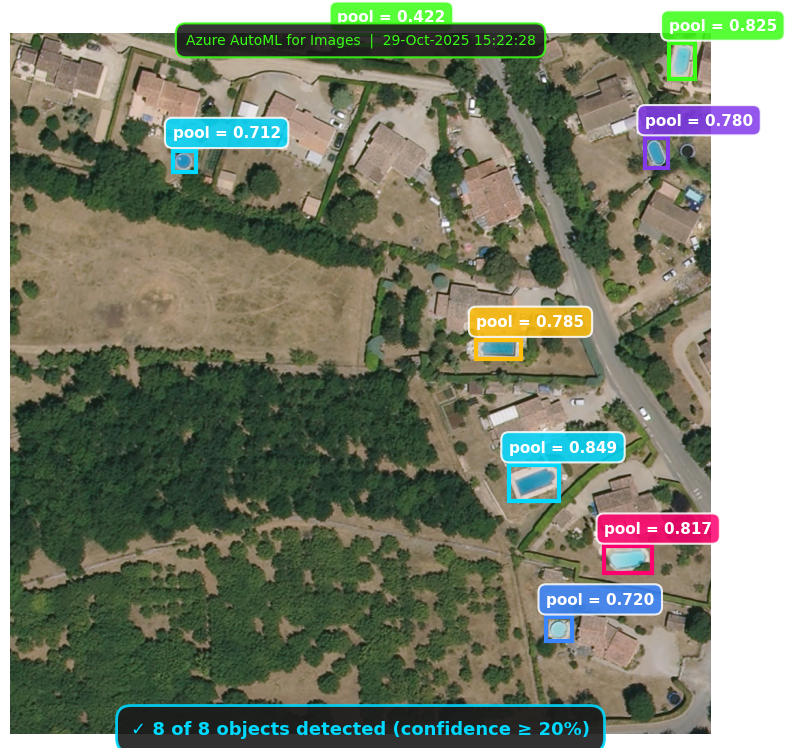

In [25]:
visualize_predictions(test_image, predictions, min_confidence=0.2)

## 4. Batch mode

In [26]:
print("🏃 Running the object detection model on all files of directory 'test'...\n")

start = time.time()
df = None

for idx, image_file in enumerate(test_images_list):
    print(f"{idx+1:03} Analysing '{test_images_list[idx]}'")
    predictions, df = pools_detection(image_file, df if df is not None else None, view=False)
    if predictions == [{'boxes': []}]:  # for empty predictions
        new_row = {col: np.nan for col in df.columns}
        new_row['image_file'] = image_file
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"\n⌛ Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")
time_per_image =  elapsed / len(test_images_list)
print(f"⏰ Average time per image = {time_per_image:.3f} seconds")

🏃 Running the object detection model on all files of directory 'test'...

001 Analysing 'test/image_001.png'
002 Analysing 'test/image_002.png'
003 Analysing 'test/image_003.png'
004 Analysing 'test/image_004.png'
005 Analysing 'test/image_005.png'
006 Analysing 'test/image_006.png'
007 Analysing 'test/image_007.png'
008 Analysing 'test/image_008.png'
009 Analysing 'test/image_009.png'
010 Analysing 'test/image_010.png'
011 Analysing 'test/image_011.png'
012 Analysing 'test/image_012.png'
013 Analysing 'test/image_013.png'
014 Analysing 'test/image_014.png'
015 Analysing 'test/image_015.png'
016 Analysing 'test/image_016.png'
017 Analysing 'test/image_017.png'
018 Analysing 'test/image_018.png'
019 Analysing 'test/image_019.png'
020 Analysing 'test/image_020.png'
021 Analysing 'test/image_021.png'
022 Analysing 'test/image_022.png'
023 Analysing 'test/image_023.png'
024 Analysing 'test/image_024.png'
025 Analysing 'test/image_025.png'
026 Analysing 'test/image_026.png'
027 Analysing 't

### All results

In [27]:
df.sort_values(by='score', ascending=False).style.background_gradient(subset=['score'], cmap='RdYlGn')

### Images with no swimming pools

In [28]:
nb_nan_rows = df['label'].isna().sum()
print(f"🚫 Number of images with non detected swimming pools = {nb_nan_rows}")

🚫 Number of images with non detected swimming pools = 29


In [29]:
rows_with_nan = df[df['score'].isna()]
rows_with_nan

image_file detection_id label  score  top_x  top_y  bottom_x  \
3    test/image_003.png          NaN   NaN    NaN    NaN    NaN       NaN   
11   test/image_008.png          NaN   NaN    NaN    NaN    NaN       NaN   
12   test/image_009.png          NaN   NaN    NaN    NaN    NaN       NaN   
13   test/image_010.png          NaN   NaN    NaN    NaN    NaN       NaN   
20   test/image_013.png          NaN   NaN    NaN    NaN    NaN       NaN   
28   test/image_016.png          NaN   NaN    NaN    NaN    NaN       NaN   
29   test/image_017.png          NaN   NaN    NaN    NaN    NaN       NaN   
31   test/image_019.png          NaN   NaN    NaN    NaN    NaN       NaN   
32   test/image_020.png          NaN   NaN    NaN    NaN    NaN       NaN   
62   test/image_028.png          NaN   NaN    NaN    NaN    NaN       NaN   
64   test/image_030.png          NaN   NaN    NaN    NaN    NaN       NaN   
97   test/image_038.png          NaN   NaN    NaN    NaN    NaN       NaN   
98   test/image_039.png          NaN   NaN    NaN    NaN    NaN       NaN   
99   test/image_040.png          NaN   NaN    NaN    NaN    NaN       NaN   
100  test/image_041.png          NaN   NaN    NaN    NaN    NaN       NaN   
225  test/image_061.png          NaN   NaN    NaN    NaN    NaN       NaN   
226  test/image_062.png          NaN   NaN    NaN    NaN    NaN       NaN   
278  test/image_071.png          NaN   NaN    NaN    NaN    NaN       NaN   
279  test/image_072.png          NaN   NaN    NaN    NaN    NaN       NaN   
280  test/image_073.png          NaN   NaN    NaN    NaN    NaN       NaN   
347  test/image_081.png          NaN   NaN    NaN    NaN    NaN       NaN   
348  test/image_082.png          NaN   NaN    NaN    NaN    NaN       NaN   
349  test/image_083.png          NaN   NaN    NaN    NaN    NaN       NaN   
407  test/image_091.png          NaN   NaN    NaN    NaN    NaN       NaN   
408  test/image_092.png          NaN   NaN    NaN    NaN    NaN       NaN   
409  test/image_093.png          NaN   NaN    NaN    NaN    NaN       NaN   
410  test/image_094.png          NaN   NaN    NaN    NaN    NaN       NaN   
412  test/image_096.png          NaN   NaN    NaN    NaN    NaN       NaN   
418  test/image_100.png          NaN   NaN    NaN    NaN    NaN       NaN   

     bottom_y confidence_level  
3         NaN              NaN  
11        NaN              NaN  
12        NaN              NaN  
13        NaN              NaN  
20        NaN              NaN  
28        NaN              NaN  
29        NaN              NaN  
31        NaN              NaN  
32        NaN              NaN  
62        NaN              NaN  
64        NaN              NaN  
97        NaN              NaN  
98        NaN              NaN  
99        NaN              NaN  
100       NaN              NaN  
225       NaN              NaN  
226       NaN              NaN  
278       NaN              NaN  
279       NaN              NaN  
280       NaN              NaN  
347       NaN              NaN  
348       NaN              NaN  
349       NaN              NaN  
407       NaN              NaN  
408       NaN              NaN  
409       NaN              NaN  
410       NaN              NaN  
412       NaN              NaN  
418       NaN              NaN

### Distribution of confidence level

In [30]:
df['confidence_level'].value_counts(sort=True, normalize=True)

High      0.420513
Medium    0.379487
Low       0.200000
Name: confidence_level, dtype: float64

### Search for a specific image file

In [31]:
image = 'test/image_098.png'

In [32]:
df[df['image_file'] == image]

image_file detection_id label     score     top_x     top_y  \
414  test/image_098.png            1  POOL  0.867239  0.803444  0.437459   
415  test/image_098.png            2  POOL  0.786800  0.761283  0.001158   
416  test/image_098.png            3  POOL  0.525928  0.168375  0.970295   

     bottom_x  bottom_y confidence_level  
414  0.853553  0.535578             High  
415  0.823458  0.028663           Medium  
416  0.216420  0.996311              Low

### List of low levels scores

In [33]:
df[df['confidence_level'] == 'Low']

image_file detection_id label     score     top_x     top_y  \
4    test/image_004.png            1  POOL  0.644398  0.876418  0.023245   
5    test/image_005.png            1  POOL  0.170509  0.579622  0.000000   
8    test/image_006.png            3  POOL  0.551707  0.352074  0.182092   
9    test/image_006.png            4  POOL  0.162164  0.746217  0.309634   
10   test/image_007.png            1  POOL  0.244690  0.156229  0.383006   
..                  ...          ...   ...       ...       ...       ...   
399  test/image_089.png           14  POOL  0.471607  0.041625  0.865683   
405  test/image_090.png            6  POOL  0.646516  0.453193  0.395082   
406  test/image_090.png            7  POOL  0.580347  0.000000  0.615357   
413  test/image_097.png            1  POOL  0.670549  0.616812  0.133669   
416  test/image_098.png            3  POOL  0.525928  0.168375  0.970295   

     bottom_x  bottom_y confidence_level  
4    0.914214  0.050376              Low  
5    0.618322  0.013030              Low  
8    0.419477  0.223342              Low  
9    0.798594  0.339124              Low  
10   0.216986  0.456333              Low  
..        ...       ...              ...  
399  0.071697  0.898320              Low  
405  0.504455  0.419194              Low  
406  0.042809  0.645888              Low  
413  0.680098  0.187169              Low  
416  0.216420  0.996311              Low  

[78 rows x 9 columns]

### List of scores less than a specific value

In [34]:
df[df['score'] <= 0.35]

image_file detection_id label     score     top_x     top_y  \
5    test/image_005.png            1  POOL  0.170509  0.579622  0.000000   
9    test/image_006.png            4  POOL  0.162164  0.746217  0.309634   
10   test/image_007.png            1  POOL  0.244690  0.156229  0.383006   
19   test/image_012.png            4  POOL  0.306056  0.000918  0.636064   
25   test/image_014.png            5  POOL  0.152867  0.604214  0.845822   
81   test/image_034.png            9  POOL  0.130275  0.955324  0.764402   
115  test/image_043.png           10  POOL  0.125806  0.563534  0.174863   
132  test/image_045.png            7  POOL  0.113125  0.000807  0.025906   
141  test/image_046.png            9  POOL  0.345866  0.881503  0.211358   
151  test/image_047.png           10  POOL  0.226156  0.931699  0.739197   
182  test/image_054.png            5  POOL  0.190796  0.229314  0.957279   
186  test/image_055.png            4  POOL  0.223208  0.183968  0.920918   
208  test/image_057.png           12  POOL  0.120142  0.762912  0.693691   
219  test/image_058.png           11  POOL  0.217968  0.724595  0.183754   
234  test/image_064.png            5  POOL  0.276381  0.656112  0.257331   
254  test/image_067.png           11  POOL  0.234950  0.155811  0.000318   
255  test/image_067.png           12  POOL  0.158814  0.000000  0.334625   
265  test/image_068.png           10  POOL  0.335062  0.000658  0.296417   
285  test/image_074.png            5  POOL  0.169205  0.784610  0.986633   
305  test/image_076.png           15  POOL  0.203259  0.000247  0.738605   
316  test/image_077.png           11  POOL  0.255403  0.110464  0.784748   
337  test/image_079.png           11  POOL  0.349182  0.578646  0.463501   
346  test/image_080.png            9  POOL  0.158237  0.244934  0.618518   
356  test/image_084.png            7  POOL  0.132512  0.691895  0.876366   
364  test/image_085.png            8  POOL  0.119375  0.798060  0.082768   

     bottom_x  bottom_y confidence_level  
5    0.618322  0.013030              Low  
9    0.798594  0.339124              Low  
10   0.216986  0.456333              Low  
19   0.016376  0.663815              Low  
25   0.632012  0.878996              Low  
81   0.978837  0.786227              Low  
115  0.598845  0.193238              Low  
132  0.031206  0.099407              Low  
141  0.914339  0.242394              Low  
151  0.965610  0.781141              Low  
182  0.253948  0.973368              Low  
186  0.206107  0.943751              Low  
208  0.792204  0.717382              Low  
219  0.751686  0.208399              Low  
234  0.699702  0.288428              Low  
254  0.231150  0.014730              Low  
255  0.068105  0.384615              Low  
265  0.027866  0.333412              Low  
285  0.817231  0.998508              Low  
305  0.017371  0.801064              Low  
316  0.140961  0.808399              Low  
337  0.627969  0.502883              Low  
346  0.271989  0.634853              Low  
356  0.717148  0.903339              Low  
364  0.821505  0.107139              Low

### Bar chart of confidence levels

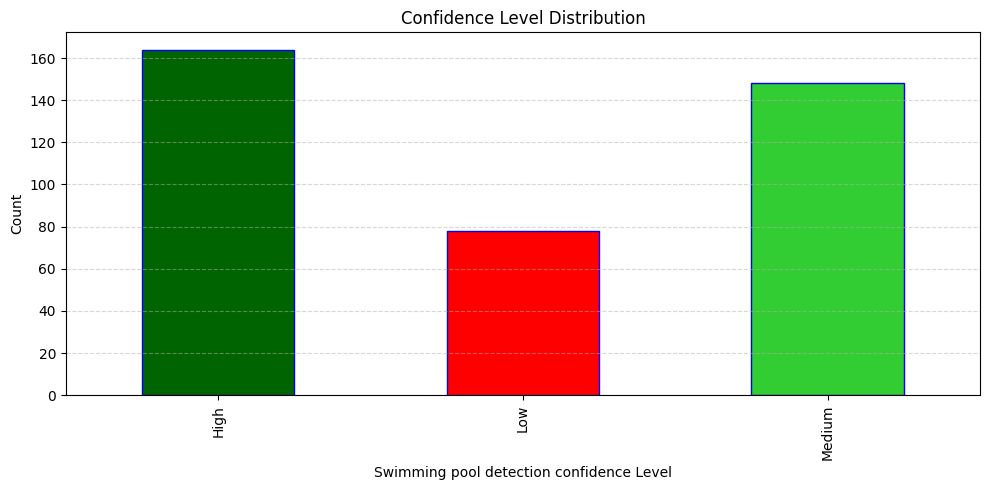

In [36]:
color_map = {
    'High': '#006400',
    'Medium': '#32CD32',
    'Low': 'red'
}

value_counts = df['confidence_level'].value_counts().sort_index()
colors = [color_map[level] for level in value_counts.index]

plt.figure(figsize=(10, 5))
value_counts.plot(
    kind='bar',
    color=colors,
    edgecolor='blue'
)
plt.title('Confidence Level Distribution', fontsize=12)
plt.xlabel('Swimming pool detection confidence Level', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "batch_confidence_level.png"))
plt.show()

## 5. Gradio webapp

In [37]:
def pools_detection(
        image_file: str,
        results_df: pd.DataFrame = None) -> Tuple[dict, pd.DataFrame]:
    """
    Detect pools in an image using an Azure ML online endpoint and store results in a DataFrame.
    
    Args:
        image_file (str): Path to the image file.
        results_df: Existing DataFrame to append results to.
    
    Returns:
        Tuple[dict, pd.DataFrame]: JSON response from the endpoint and updated DataFrame.
    """
    try:
        # Initialize DataFrame if not provided
        if results_df is None:
            results_df = pd.DataFrame(columns=[
                'image_file', 'detection_id', 'label', 'score', 'top_x',
                'top_y', 'bottom_x', 'bottom_y', 'confidence_level'
            ])

        # Read and encode image
        with open(image_file, "rb") as img:
            encoded_image = base64.encodebytes(img.read()).decode("utf-8")

        # Prepare request payload
        request_json = {
            "input_data": {
                "columns": ["image"],
                "data": [encoded_image],
            }
        }

        # Save request to file
        request_file_name = os.path.join(MODEL_DIR, "request.json")
        with open(request_file_name, "w") as request_file:
            json.dump(request_json, request_file)

        # Invoke endpoint
        response = ml_client.online_endpoints.invoke(
            endpoint_name=online_endpoint_name,
            deployment_name=deployment_name,
            request_file=request_file_name,
        )

        results = json.loads(response)

        for item_idx, item in enumerate(results, 1):
            boxes = item.get('boxes', [])

            for box_idx, detection in enumerate(boxes, 1):
                label = detection.get('label', 'unknown').upper()
                score = detection.get('score', 0)
                box = detection.get('box', {})

                # Determine confidence level based on score
                if score >= 0.80:
                    confidence_level = "High"
                elif score >= 0.70:
                    confidence_level = "Medium"
                else:
                    confidence_level = "Low"

                top_x = box.get('topX', 0)
                top_y = box.get('topY', 0)
                bottom_x = box.get('bottomX', 0)
                bottom_y = box.get('bottomY', 0)

                # Append detection to DataFrame
                new_row = {
                    'image_file': image_file,
                    'detection_id': box_idx,
                    'label': label,
                    'score': score,
                    'top_x': top_x,
                    'top_y': top_y,
                    'bottom_x': bottom_x,
                    'bottom_y': bottom_y,
                    'confidence_level': confidence_level
                }
                results_df = pd.concat(
                    [results_df, pd.DataFrame([new_row])], ignore_index=True)

        return results, results_df

    except FileNotFoundError:
        raise ValueError(f"Image file '{image_file}' not found.")
    except Exception as e:
        raise RuntimeError(f"Error during pool detection: {e}")


def visualize_predictions(image_file,
                          predictions,
                          min_confidence=0.7,
                          figsize=(12, 12)):
    """
    Display an image with beautifully styled bounding boxes for predictions above a confidence threshold.
    
    Parameters:
    - image_file (str): Path to the image file.
    - predictions (list): List of prediction dictionaries with 'label', 'score', and 'box'.
    - min_confidence (float): Minimum confidence to display a bounding box.
    - figsize (tuple): Size of the matplotlib figure.
    
    Returns:
    - PIL.Image: Annotated image
    """
    # Load image
    image_array = mpimg.imread(image_file)
    pil_image = Image.fromarray(image_array.astype("uint8"))
    image_width, image_height = pil_image.size

    # Create plot with white background
    fig, axis = plt.subplots(1, figsize=figsize, facecolor='white', dpi=100)
    axis.set_facecolor('white')
    plt.axis('off')
    axis.imshow(image_array)

    # Color palette for boxes - vibrant and distinguishable colors
    colors = ["#00D9FF", "#39FF14", "#FF006E", "#FFBE0B", "#8338EC", "#3A86FF"]

    detected_count = 0

    # Draw bounding boxes
    for idx, detection in enumerate(predictions[0]["boxes"]):
        confidence = detection["score"]
        if confidence >= min_confidence:
            detected_count += 1

            bbox = detection["box"]
            y_start, x_start = bbox["topY"], bbox["topX"]
            y_end, x_end = bbox["bottomY"], bbox["bottomX"]
            box_left = image_width * x_start
            box_top = image_height * y_start
            box_width = image_width * (x_end - x_start)
            box_height = image_height * (y_end - y_start)

            # Select color
            box_color = colors[idx % len(colors)]

            # Draw rectangle with thicker, more prominent border
            bounding_box = patches.Rectangle(xy=(box_left, box_top),
                                             width=box_width,
                                             height=box_height,
                                             linewidth=5,
                                             edgecolor=box_color,
                                             facecolor="none",
                                             linestyle='-')
            axis.add_patch(bounding_box)

            # Add background for label text (semi-transparent rectangle)
            label_text = f"{detection['label']} = {confidence:.3f}"
            bbox_props = dict(boxstyle='round,pad=0.5',
                              facecolor=box_color,
                              alpha=0.85,
                              edgecolor='white',
                              linewidth=1.5)
            plt.text(box_left,
                     box_top - 15,
                     label_text,
                     color='white',
                     fontsize=15,
                     weight='bold',
                     bbox=bbox_props,
                     verticalalignment='bottom')

    # Add header info with styled background
    total_boxes = len(predictions[0]['boxes'])
    header_text = f"✓ {detected_count} of {total_boxes} objects detected (confidence ≥ {min_confidence:.0%})"
    now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')

    # Header background
    header_props = dict(boxstyle='round,pad=0.8',
                        facecolor='#1a1a1a',
                        alpha=0.9,
                        edgecolor='#00D9FF',
                        linewidth=5)
    
    plt.text(image_width * 0.5,
             image_height * 0.98,
             header_text,
             color='#00D9FF',
             fontsize=18,
             weight='bold',
             ha='center',
             va='top',
             bbox=header_props,
             transform=axis.transData)

    # Footer info
    footer_props = dict(boxstyle='round,pad=0.7',
                        facecolor='#1a1a1a',
                        alpha=0.88,
                        edgecolor='#39FF14',
                        linewidth=1.5)
    
    plt.text(image_width * 0.5,
             image_height * 0.02,
             f"Azure AutoML for Images  |  {now}",
             color='#39FF14',
             fontsize=18,
             ha='center',
             va='bottom',
             bbox=footer_props,
             transform=axis.transData)

    plt.tight_layout()

    # Convert to PIL Image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', facecolor='white')
    buf.seek(0)
    result_image = Image.open(buf)
    plt.close()

    return result_image


def process_image(image, confidence_threshold):
    """
    Main processing function for Gradio interface.
    
    Args:
        image: Input image from Gradio
        confidence_threshold: Minimum confidence threshold for detections
    
    Returns:
        Tuple: (annotated_image, dataframe, summary_html)
    """
    if image is None:
        return None, None, "<div style='color: red;'>❌ Please upload an image first!</div>"

    try:
        # Save uploaded image temporarily
        temp_image_path = os.path.join(RESULTS_DIR, "temp_upload.jpg")
        if isinstance(image, np.ndarray):
            Image.fromarray(image).save(temp_image_path)
        else:
            image.save(temp_image_path)

        # Run detection
        predictions, results_df = pools_detection(temp_image_path)

        # Generate visualization
        annotated_image = visualize_predictions(
            temp_image_path, predictions, min_confidence=confidence_threshold)

        # Generate summary statistics
        total_detections = len(
            predictions[0]
            ['boxes']) if predictions and predictions[0].get('boxes') else 0
        high_conf = len(results_df[results_df['confidence_level'] == 'High'])
        medium_conf = len(
            results_df[results_df['confidence_level'] == 'Medium'])
        low_conf = len(results_df[results_df['confidence_level'] == 'Low'])
        avg_score = results_df['score'].mean() if not results_df.empty else 0

        summary_html = f"""
        <div style='background: linear-gradient(135deg, #bfdbfe 0%, #dbeafe 100%); 
                    padding: 25px; border-radius: 15px; color: #1e3a8a; 
                    box-shadow: 0 10px 30px rgba(0,0,0,0.1);'>
            <h2 style='margin: 0 0 20px 0; font-size: 20px;'>🏊 Detection Summary</h2>
            <div style='display: grid; grid-template-columns: repeat(2, 1fr); gap: 15px;'>
                <div style='background: rgba(59, 130, 246, 0.15); padding: 15px; border-radius: 10px;'>
                    <div style='font-size: 36px; font-weight: bold;'>{total_detections}</div>
                    <div style='font-size: 14px; opacity: 0.8;'>Total Pools Detected</div>
                </div>
                <div style='background: rgba(59, 130, 246, 0.15); padding: 15px; border-radius: 10px;'>
                    <div style='font-size: 36px; font-weight: bold;'>{avg_score:.1%}</div>
                    <div style='font-size: 14px; opacity: 0.8;'>Average Confidence</div>
                </div>
                <div style='background: rgba(96, 165, 250, 0.25); padding: 15px; border-radius: 10px;'>
                    <div style='font-size: 28px; font-weight: bold;'>🔵 {high_conf}</div>
                    <div style='font-size: 14px; opacity: 0.8;'>High Confidence (≥80%)</div>
                </div>
                <div style='background: rgba(147, 197, 253, 0.3); padding: 15px; border-radius: 10px;'>
                    <div style='font-size: 28px; font-weight: bold;'>🔷 {medium_conf}</div>
                    <div style='font-size: 14px; opacity: 0.8;'>Medium Confidence (70-80%)</div>
                </div>
            </div>
            <div style='margin-top: 15px; padding: 12px; background: rgba(59, 130, 246, 0.1); 
                        border-radius: 8px; font-size: 13px;'>
                ✨ Processed at {datetime.datetime.now().strftime('%H:%M:%S on %d %B %Y')}
            </div>
        </div>
        """

        # Format DataFrame for display
        display_df = results_df.copy()
        if not display_df.empty:
            display_df['score'] = display_df['score'].apply(
                lambda x: f"{x:.2%}")
            display_df = display_df[[
                'detection_id', 'label', 'score', 'confidence_level', 'top_x',
                'top_y', 'bottom_x', 'bottom_y'
            ]]

        return annotated_image, display_df, summary_html

    except Exception as e:
        error_html = f"""
        <div style='background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); 
                    padding: 20px; border-radius: 10px; color: white;'>
            <h3>❌ Error During Detection</h3>
            <p style='font-family: monospace; font-size: 14px;'>{str(e)}</p>
        </div>
        """
        return None, None, error_html


def export_results_to_csv(dataframe):
    """Export results to CSV file."""
    if dataframe is None or dataframe.empty:
        return None

    csv_path = f"pool_detection_results_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    dataframe.to_csv(csv_path, index=False)
    return csv_path


# Create Gradio interface
with gr.Blocks(theme=gr.themes.Soft(), title="Pool Detection AI") as webapp:

    # Header
    gr.Markdown("""
        # 🏊 Pool Detection AI
        ### Powered by Azure AutoML for Images
        
        Upload an aerial or satellite image to automatically detect swimming pools using advanced computer vision.
        """)

    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### 📤 Upload Image")
            input_image = gr.Image(label="Your image",
                                   type="numpy",
                                   height=600,
                                   sources=["upload", "clipboard"])

            confidence_slider = gr.Slider(
                minimum=0.0,
                maximum=1.0,
                value=0.7,
                step=0.05,
                label="🎯 Confidence Threshold",
                info="Minimum confidence level for detections")

            with gr.Row():
                detect_btn = gr.Button("🔍 Detect Pools",
                                       variant="primary",
                                       size="lg",
                                       elem_classes="primary-button")
                clear_btn = gr.ClearButton(components=[input_image],
                                           value="🗑️ Clear",
                                           size="lg")

        with gr.Column(scale=1):
            gr.Markdown("### 📊 Results")
            output_image = gr.Image(label="Detected Pools",
                                    type="pil",
                                    height=600)

            summary_html = gr.HTML(label="Statistics")

    # Results section
    with gr.Row():
        with gr.Column():
            gr.Markdown("### 📋 Detailed Detection Data")
            results_table = gr.DataFrame(label="Detection Details",
                                         wrap=True,
                                         interactive=False)

            export_btn = gr.Button("💾 Export to CSV", variant="secondary")
            download_file = gr.File(label="Download Results", visible=True)

    # Examples section
    gr.Markdown("### 🎨 Samples")
    gr.Examples(
        examples=[
            # Add paths to example images if you have them
            ["test/image_001.png"],
            ["test/image_021.png"],
            ["test/image_035.png"],
            ["test/image_076.png"],
            ["test/image_085.png"],
            ["test/image_086.png"],
        ],
        inputs=input_image,
        label="Examples")

    # Footer
    gr.Markdown("""
        ---
        <div style='text-align: center; color: #666; font-size: 14px; padding: 20px;'>
            <p>🤖 Powered by AutoML for Images Azure Machine Learning</p>
            <p>For best results, use high-resolution aerial or satellite imagery</p>
        </div>
        """)

    # Event handlers
    detect_btn.click(fn=process_image,
                     inputs=[input_image, confidence_slider],
                     outputs=[output_image, results_table, summary_html])

    export_btn.click(fn=export_results_to_csv,
                     inputs=[results_table],
                     outputs=[download_file])

In [38]:
webapp.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://9c3ccdc2dc635f7645.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


![Alt text](img/gradio1.jpg)
![Alt text](img/gradio2.jpg)

> Go to the next notebook